In [3]:
import dask.dataframe as dd
import geopandas 
import pandas as pd

from shapely import wkt

# Meta and Ookla

The following is an example illustrating the [Development Data Partnership Template](https://datapartnership.org/template) - a flexible *project* and *documentation* structure of folders and files for sharing your data science work. 

```{important}
Please note that none of the results should be used as face value. 
```

## Rationale

The [Development Data Partnership](https://datapartnership.org/) is a collaboration between international organizations and technology companies, facilitating the efficient and responsible use of third-party data in international development. 

Through the program, Data Partners provide private and publicly available data, such as:

- [Ookla for Good](https://www.ookla.com/ookla-for-good)'s [Global Fixed Broadband & Mobile Network Maps](https://registry.opendata.aws/speedtest-global-performance) that include both fixed (and Wi-Fi) and mobile performance measurements around the world, collected via Ookla’s Android and iOS Speedtest apps and averaged for each tile. 

- [Data for Good at Meta](https://dataforgood.facebook.com)'s [High Resolutation Resolution Density Maps](https://dataforgood.facebook.com/dfg/tools/high-resolution-population-density-maps) that include population density estimates created in collaboration with CIESEN.

The idea is combine these data to estimate the population breakdown by quantitle based on average download speed.

## Reading Data

### Global Fixed Broadband & Mobile Network Maps

The data is publicly available on the Registry of Open Data on AWS. Let's retrieve the data files.

In [4]:
ddf = dd.read_parquet(
    "s3://ookla-open-data/parquet/performance/type=mobile/year=2022/quarter=1/*.parquet", 
    storage_options={"anon": True}
)

In [5]:
ddf.head()

,quadkey,tile,avg_d_kbps,avg_u_kbps,avg_lat_ms,tests,devices
0,0022133222330201,"POLYGON((-160.043334960938 70.6344840663086, -...",17574,18136,69,8,1
1,0022133222330203,"POLYGON((-160.043334960938 70.6326624870732, -...",13320,18395,70,3,1
2,0022332203013331,"POLYGON((-162.603149414062 66.8999063523575, -...",3301,1121,53,32,2
3,0022332203031111,"POLYGON((-162.603149414062 66.8955956114071, -...",3529,264,52,1,1
4,0022332203102203,"POLYGON((-162.592163085938 66.9020614377385, -...",1320,534,67,1,1


Selecting Costa Rica,

```{image} ../docs/images/CRI_quadkey.png
:width: 600px
:align: center
```

In [6]:
df = ddf[ddf["quadkey"].str.startswith("03222")].compute()

# convert to geometry
df["tile"] = geopandas.GeoSeries.from_wkt(df["tile"], crs="EPSG:4326")

Creating `geopandas.GeoDataFrame`

In [7]:
OOKLA = geopandas.GeoDataFrame(df, geometry="tile", crs="EPSG:4326")

**Voilà!**

### High Resolution Population Density Maps

Through [Data for Good at Meta](https://dataforgood.facebook.com), the High Resolution Population Density Maps are openly available via HDX. In this example, we retrieve [Costa Rica](https://data.humdata.org/dataset/costa-rica-high-resolution-population-density-maps-demographic-estimates) clipped on the extent.



In [8]:
CRI = geopandas.read_file("../data/interim/CRI_quadkey_HRSL.geojson")

**Voilà!**

## Joining

In [9]:
result = pd.merge(CRI, OOKLA, how="inner", on="quadkey")

In [10]:
result = result[["Population", "avg_d_kbps", "tile"]].set_geometry("tile") 

## Visualizations

Finally, let's take a quick peek. 

In [11]:
result.explore()

### Calculating quantiles

In [12]:
result["Quantile"] = pd.qcut(result["avg_d_kbps"], q=4, labels=["Q1", "Q2", "Q3", "Q4"], precision=0)
result["Quantile"] = result["Quantile"].astype(str) 

In [13]:
result.explore(column="Quantile", cmap="magma")

### Population by quantiles

Finally, we breakdown the population by the `avg_d_kbps` quantiles.

In [14]:
result = result.groupby("Quantile")["Population"].sum()

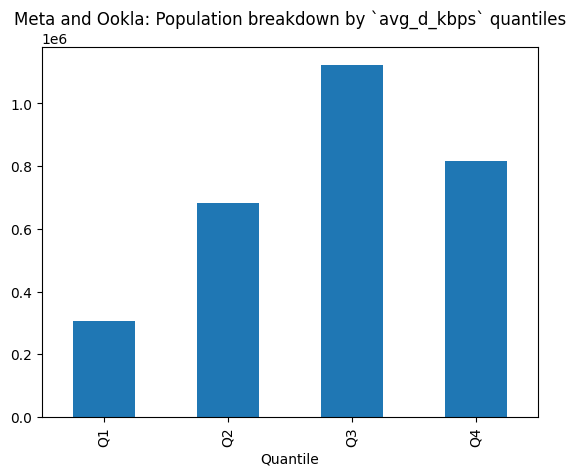

In [15]:
result.plot(title="Meta and Ookla: Population breakdown by `avg_d_kbps` quantiles", kind="bar");